In [1]:
# to execute, you need to install the openPMD viewer, see their documentation

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

from matplotlib import patches
from matplotlib import ticker

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# </path/to>/build/bin/hipace <input>

In [2]:
# path to output directory
ts_test2 = LpaDiagnostics('/Users/max/HiPACE/test/diags/hdf5/', check_all_files=False)


In [3]:
ExmBy, info_x = ts_test2.get_field(field='ExmBy', iteration=0)
Ez, info_x = ts_test2.get_field(field='Ez', iteration=0)

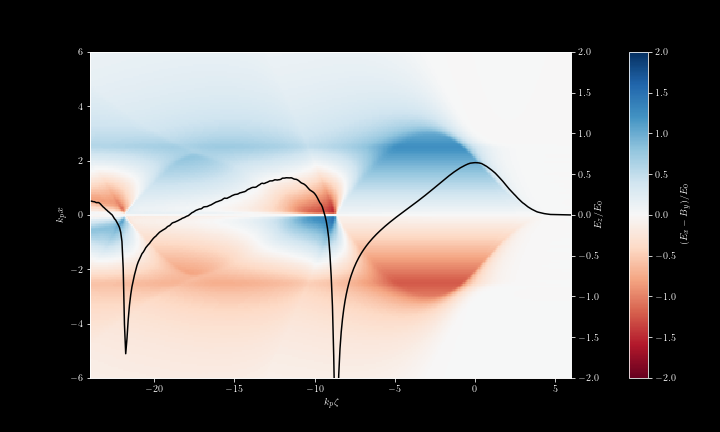

In [6]:
fig, ax =plt.subplots(1,1, figsize=(10,6))


im = ax.pcolormesh(info_x.z, info_x.x, np.transpose(ExmBy), cmap='RdBu', vmin=-2, vmax=2) # cmap='RdBu') 


ax.set_xlim(-24, 6)
ax.set_ylim(-6, 6)
ax.set_ylabel('$k_px$')
ax.set_xlabel('$k_p\zeta$')

# plt.style.use()

# matplotlib.rc('axes', edgecolor='k')

# ax.tick_params(colors='k')
# ax.tick_params(axis='y', colors='k')
# ax.yaxis.label.set_color('k')
# ax.xaxis.label.set_color('k')

ax2 = ax.twinx()
ax2.plot(info_x.z, np.transpose(Ez)[len(info_x.x)//2,:], color='black')
ax2.set_ylim(-2, 2)
ax2.set_ylabel(r'$E_z/E_0$',  labelpad=-5) 

divider2 = make_axes_locatable(ax)
cax2 = divider2.append_axes("right", size="4%", pad=.8)
divider3 = make_axes_locatable(ax2)
cax3 = divider3.append_axes("right", size="4%", pad=.8)
cax3.remove()

cb2 = plt.colorbar(im, cax=cax2)
cb2.set_label(r'$(E_x - B_y)/E_0 $')